In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math


In [135]:
import sys
sys.path.append('../../normalizing-flows/')
from nf.flows import *
from nf.models import NormalizingFlowModel
from nf.utils import unconstrained_RQS


In [316]:
from torch.utils.data import Dataset, DataLoader
sys.path.append('../../stlcg_karen/src')
sys.path.append('../expert_demo_ros/src/utils')

import stlcg
import stlviz
from environment import *
from src.learning import *
from src.utils import *
from src.stl import *
import importlib
# importlib.reload(learning)

In [470]:
env = { "covers": [Circle([8., 3.0], 2.0)],
       "obstacles": [Circle([4.5, 6.], 1.5)],
       "initial": Box([0., 0.],[3., 3.]),
       "final": Circle([1., 9.], 1.0)
        }   
env = Environment(env)
device = "cpu"
x_train_, u_train_, stats = prepare_data("expert/coverage/train.npy")
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])
dynamics = KinematicBicycle(0.5)
hidden_dim = 64
model0 = STLPolicy(dynamics, hidden_dim, stats, env, dropout=0., num_layers=1)


# initial conditions set
lower = torch.tensor([env.initial.lower[0], env.initial.lower[1], -np.pi/4, 0])
upper = torch.tensor([env.initial.upper[0], env.initial.upper[1], np.pi/4, 3])

ic_ = initial_conditions(128, lower, upper)
ic = model0.standardize_x(ic_)
train_loader = torch.utils.data.DataLoader(ic, batch_size=128//32, shuffle=True)


in_end_goal = inside_circle(env.final, "distance to final")
stop_in_end_goal = in_end_goal & (stlcg.Expression('speed')  < 0.5)
end_goal = stlcg.Eventually(subformula=stop_in_end_goal)
coverage = stlcg.Eventually(subformula=(always_inside_circle(env.covers[0], "distance to coverage", interval=[0,10]) & (stlcg.Expression('speed')  < 1.0)))
avoid_obs = always_outside_circle(env.obs[0], "distance to obstacle")

formula = stlcg.Until(subformula1=coverage, subformula2=end_goal) & avoid_obs
stl_graph = stlviz.make_stl_graph(formula)
stlviz.save_graph(stl_graph, "../figs/test/stl")
formula_input_func=lambda s: get_formula_input(s, env.covers[0], env.obs[0], env.final, device, backwards=False)

In [471]:
save_model_path = "models/coverage_run=1_lstm_dim=64_teacher_training=-1.0_weight_ctrl=0.5_weight_recon=1.0_weight_stl=-1.0_stl_max=0.2_stl_min=0.10_stl_scale=-1.0_scale_max=50.0_scale_min=0.10_iter_max=500.0"
checkpoint = torch.load(save_model_path + '/model')
model0.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [844]:
dt = 0.3
X, Y, TH, V = np.meshgrid(np.arange(lower[0], upper[0]+dt, dt), np.arange(lower[1], upper[1]+dt, dt), np.arange(lower[2], upper[2], dt), np.arange(lower[3], upper[3]+dt, dt))


In [845]:
x0 = model0.standardize_x(torch.stack([torch.tensor(X).view([-1,1]), torch.tensor(Y).view([-1,1]), torch.tensor(TH).view([-1,1]), torch.tensor(V).view([-1,1])], dim=-1).float())
x_future, u_future = model0.propagate_n(40, x0)
complete_traj = model0.join_partial_future_signal(x0, x_future)
Z = model0.STL_robustness(complete_traj, formula, formula_input_func, scale=-1).squeeze()

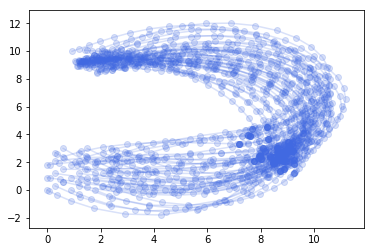

In [896]:
p = 200
traj_np = model0.unstandardize_x(complete_traj).cpu().detach().numpy()
plt.plot(traj_np[::p,:,0].T, traj_np[::p,:,1].T, alpha=0.2, c='RoyalBlue')
plt.scatter(traj_np[::p,:,0].T, traj_np[::p,:,1].T, alpha=0.2, c='RoyalBlue')

In [497]:

def plot_data(x, **kwargs):
    plt.scatter(x[:,0], x[:,1], marker="x", **kwargs)
    plt.xlim((0, 3))
    plt.ylim((0, 3))

In [846]:
def robustness_score(x0_, xmin=lower, xmax=upper):
    x0 = model0.standardize_x(x0_)
    x_future, u_future = model0.propagate_n(40, x0)
    complete_traj = model0.join_partial_future_signal(x0, x_future)
    rho = model0.STL_robustness(complete_traj, formula, formula_input_func, scale=-1).squeeze(-1)
    return torch.where((x0_ <= upper).all(-1) & (lower <= x0_).all(-1),
                       rho, 
                       torch.ones_like(rho) * 1E6)


In [871]:
dim = 4
n = 512
iterations = 500

n_samples = 2048
n_flows = 8
n_elite = 1024
iterations = 100
flow = NSF_AR
flows = [flow(dim) for _ in range(n_flows)]
prior = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = NormalizingFlowModel(prior, flows)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


In [849]:
th_list = TH[0,0,:,0]
v_list = V[0,0,0,:]

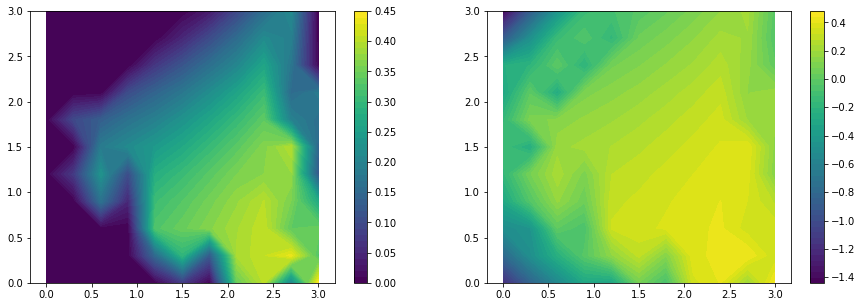

In [788]:
dt = 0.1
xmin = 0
xmax = 3
# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.figure(figsize=(15, 5))
N = 50

th = 1
v = 3

plt.subplot(1,2,1)
plt.contourf(X[:,:,th,v], Y[:,:,th,v], Z.relu().view(X.shape)[:,:,th,v].detach().numpy(), N)
plt.axis("equal")
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(X[:,:,th,v], Y[:,:,th,v], Z.view(X.shape)[:,:,th,v].detach().numpy(), N)
# ax.clabel(CS, inline=True, fontsize=10)
# plt.contourf(X, Y, Z.view(X.shape).detach().numpy(), 50)
plt.axis("equal")
plt.colorbar()
# fig.colorbar(matplotlib.cm.ScalarMappable())



## Normalizing Flow

In [872]:
N = 50
th = [0, 2, 3, 4]
v = 4
ep = 0.1

In [873]:
def get_slice(samples, idx, thresh, ep=0.1):
    return samples[(samples[:,:,idx] < thresh + ep) & (samples[:,:,idx] > thresh - ep)].unsqueeze(1)

In [879]:
model.sample(n_samples//2).data

tensor([[ 1.8555, -1.1596, -0.8322,  1.1128],
        [ 2.0236, -0.9899, -0.5642,  1.0818],
        [ 2.6195, -1.8195, -0.4975,  1.1207],
        ...,
        [ 1.9624, -1.2614, -1.1434,  1.1477],
        [ 1.8011, -1.0632, -0.5511,  0.9629],
        [ 1.8674, -1.5364, -1.8016,  1.1568]])

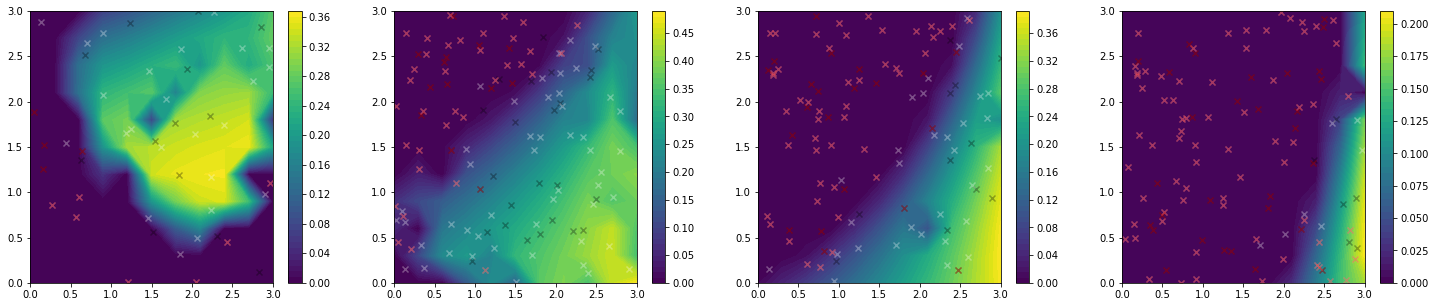

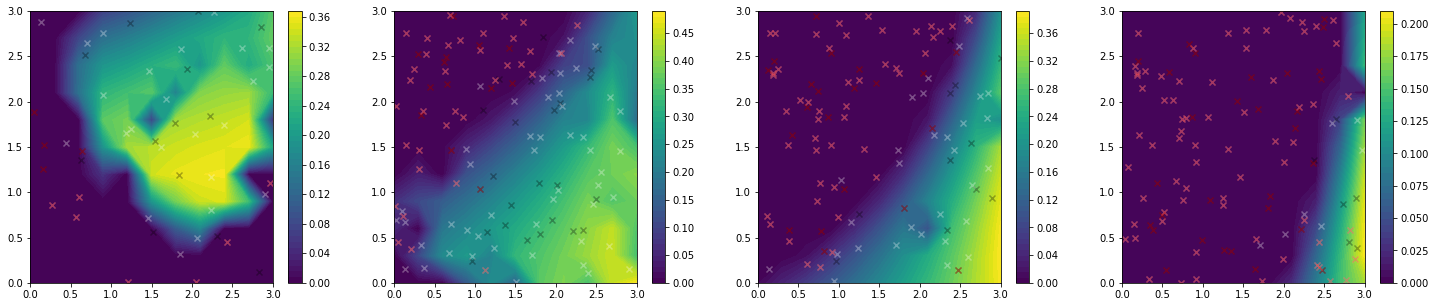

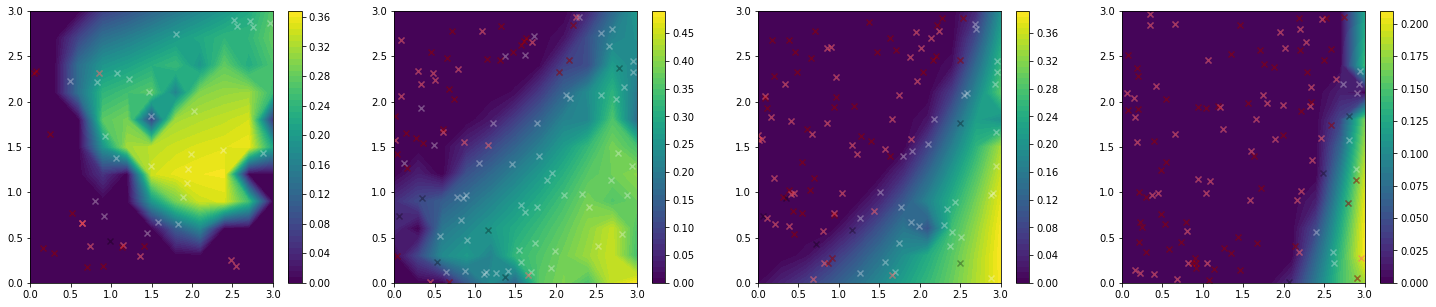

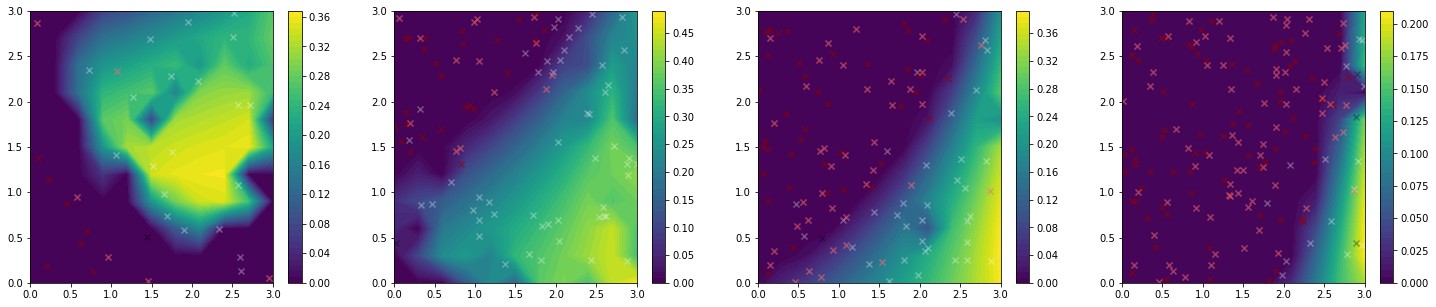

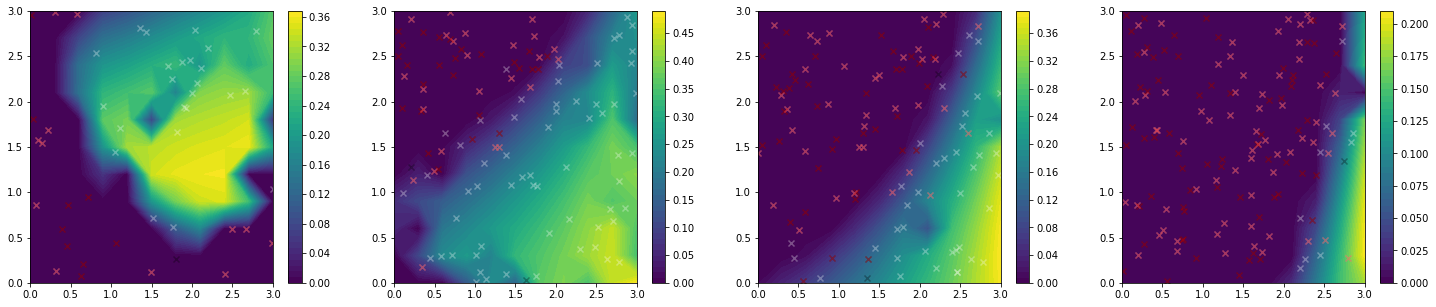

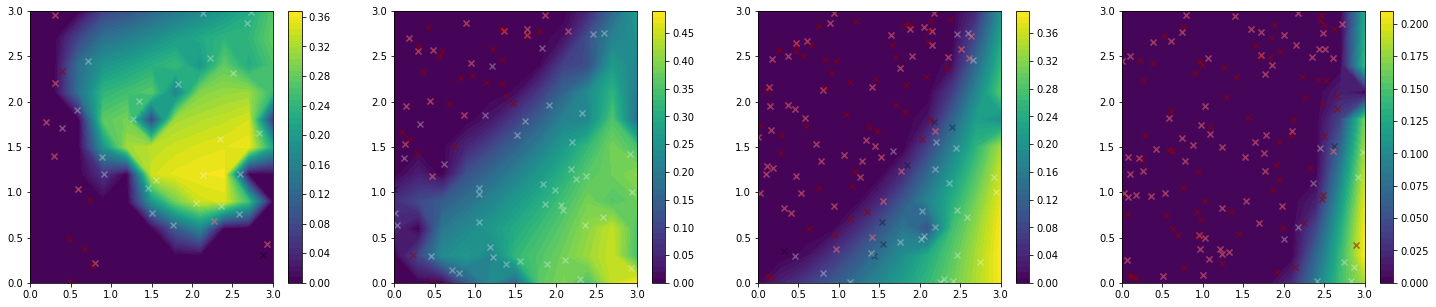

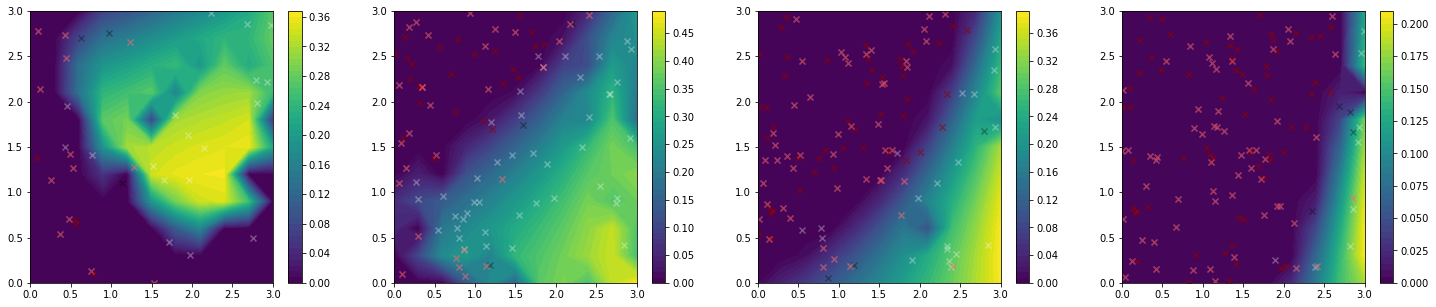

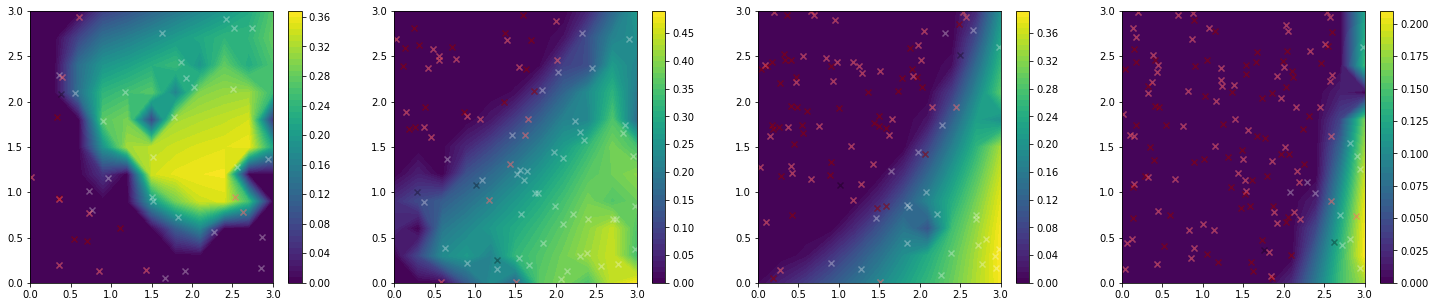

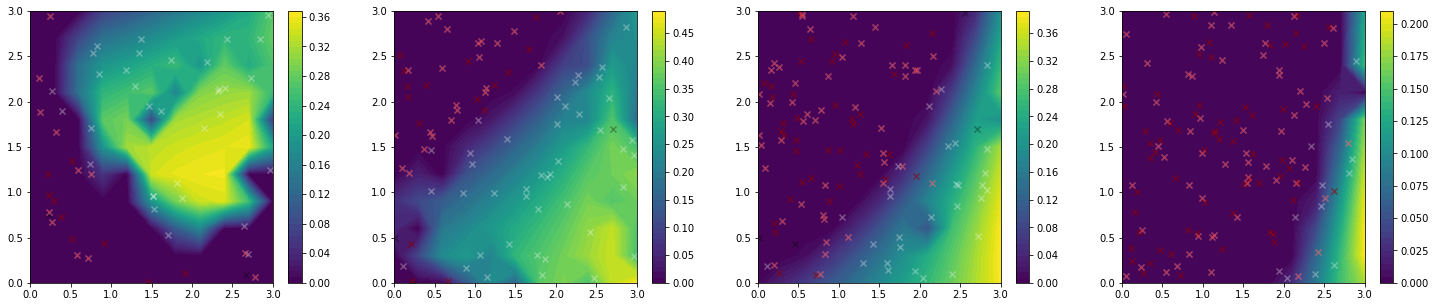

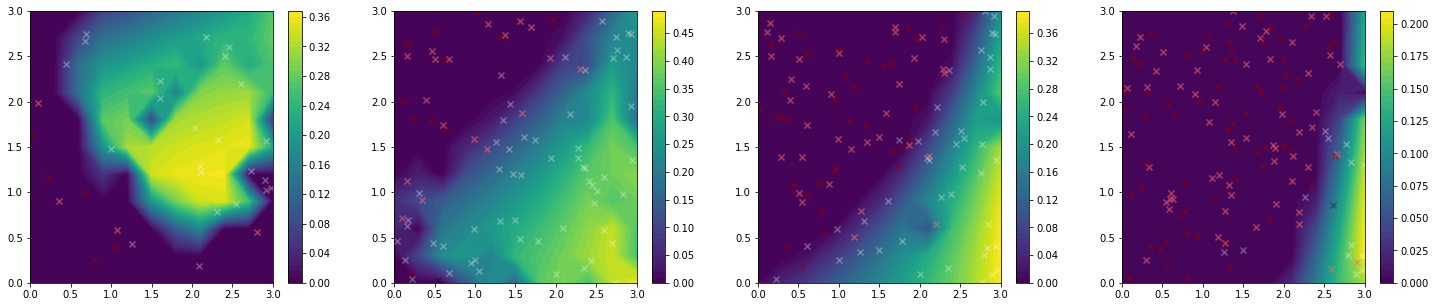

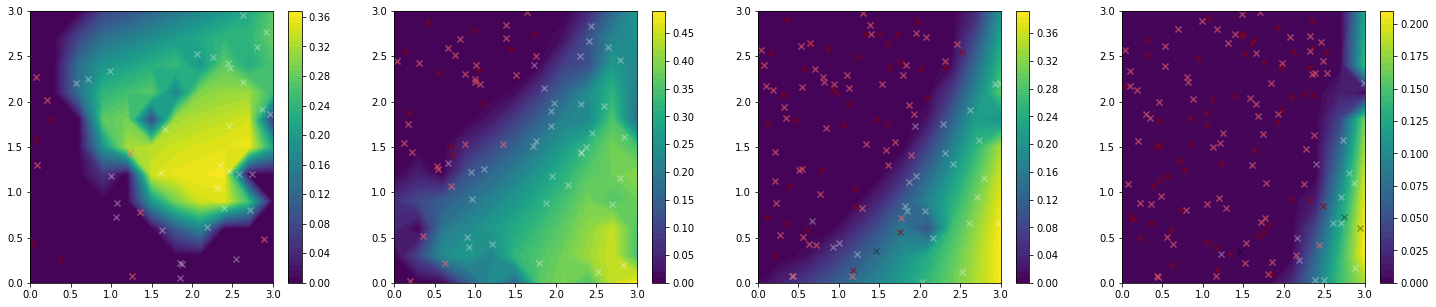

In [889]:
sample_uniform = torch.rand([n_samples, 1, dim]) * (upper - lower) + lower
# sample_uniform = torch.randn([n_samples, dim]) * (upper - lower) + lower

sample_dist = torch.rand([n_samples//2, 1, dim]) * (upper - lower) + lower
# sample_dist = torch.randn([n_samples, dim]) * (upper - lower) + lower

samples = torch.cat([sample_dist, sample_uniform], dim=0)

scores = robustness_score(samples)
# elite_idx = robustness_score(samples[:,0], samples[:,1]).sort().indices[:n_elite]
elite_samples = samples[scores < 0].unsqueeze(1)

plt.figure(figsize=(25, 5))

for (i, thi) in enumerate(th):
    plt.subplot(1,4,i+1)
    plt.contourf(X[:,:,thi,v], Y[:,:,thi,v], Z.relu().view(X.shape)[:,:,thi,v].detach().numpy(), N)
    plt.colorbar()
    slice_dist = get_slice(get_slice(sample_dist, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
    plot_data(slice_dist[:,0,:2], color="black", alpha=0.3)
    slice_uniform = get_slice(get_slice(sample_uniform, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
    plot_data(slice_uniform[:,0,:2], color="white", alpha=0.3)
    slice_elite = get_slice(get_slice(elite_samples, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
    plot_data(slice_elite[:,0,:2], color="red", alpha=0.3)
# plot_data(sample_uniform, color="white", alpha=0.3)
# plot_data(elite_samples, color="red", alpha=0.3)


plt.show()
for _ in range(10):
    for j in range(iterations):
        optimizer.zero_grad()
        z, prior_logprob, log_det = model(elite_samples.squeeze())
        logprob = prior_logprob + log_det
        loss = -torch.mean(logprob) # +  (logprob.exp() * logprob).mean()# * torch.exp(-score(elite_samples[:,0], elite_samples[:,1])))
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f"Iter: {i}\t" +
                        f"Logprob: {logprob.mean().data:.2f}\t" +
                        f"Prior: {prior_logprob.mean().data:.2f}\t" +
                        f"LogDet: {log_det.mean().data:.2f}")
    plt.figure(figsize=(25, 5))
    for (i, thi) in enumerate(th):
        plt.subplot(1,4,i+1)
        plt.contourf(X[:,:,thi,v], Y[:,:,thi,v], Z.relu().view(X.shape)[:,:,thi,v].detach().numpy(), N)
        plt.colorbar()
        slice_dist = get_slice(get_slice(sample_dist, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
        plot_data(slice_dist[:,0,:2], color="black", alpha=0.3)
        slice_uniform = get_slice(get_slice(sample_uniform, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
        plot_data(slice_uniform[:,0,:2], color="white", alpha=0.3)
        slice_elite = get_slice(get_slice(elite_samples, 2, th_list[thi], ep=0.2), 3, v_list[v], ep=0.2)
        plot_data(slice_elite[:,0,:2], color="red", alpha=0.3)
    plt.show()
    
    sample_dist = model.sample(n_samples//2).data.unsqueeze(1)
    sample_uniform = torch.rand([n_samples, 1, dim]) * (upper - lower) + lower
    samples = torch.cat([sample_dist, sample_uniform], dim=0)
    scores = robustness_score(samples)
    elite_samples = samples[scores < 0].unsqueeze(1)

In [919]:
th_list[thi]

-0.7853981852531433

In [923]:
"θ={:01f}".format(th_list[thi])

'θ=-0.785398'

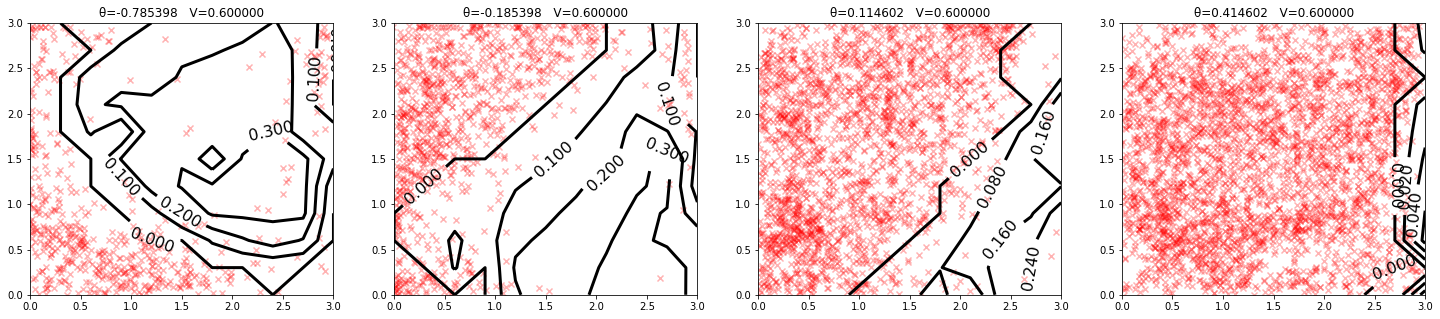

In [925]:
sample_dist = model.sample(100*n_samples).data.unsqueeze(1)
N = 3
plt.figure(figsize=(25, 5))
v=2

for (i, thi) in enumerate(th):
    plt.subplot(1,4,i+1)
    CS = plt.contour(X[:,:,thi,v], Y[:,:,thi,v], Z.relu().view(X.shape)[:,:,thi,v].detach().numpy(), N, linewidths=3, colors="black")
    plt.clabel(CS, inline=True, fontsize=16)
    slice_dist = get_slice(get_slice(sample_dist, 2, th_list[thi], ep=0.1), 3, v_list[v], ep=0.1)
    plot_data(slice_dist[:,0,:2], color="red", alpha=0.3)
    plt.title("θ={:01f}   V={:01f}".format(th_list[thi], v_list[v]))
  

In [902]:
?plt.contour

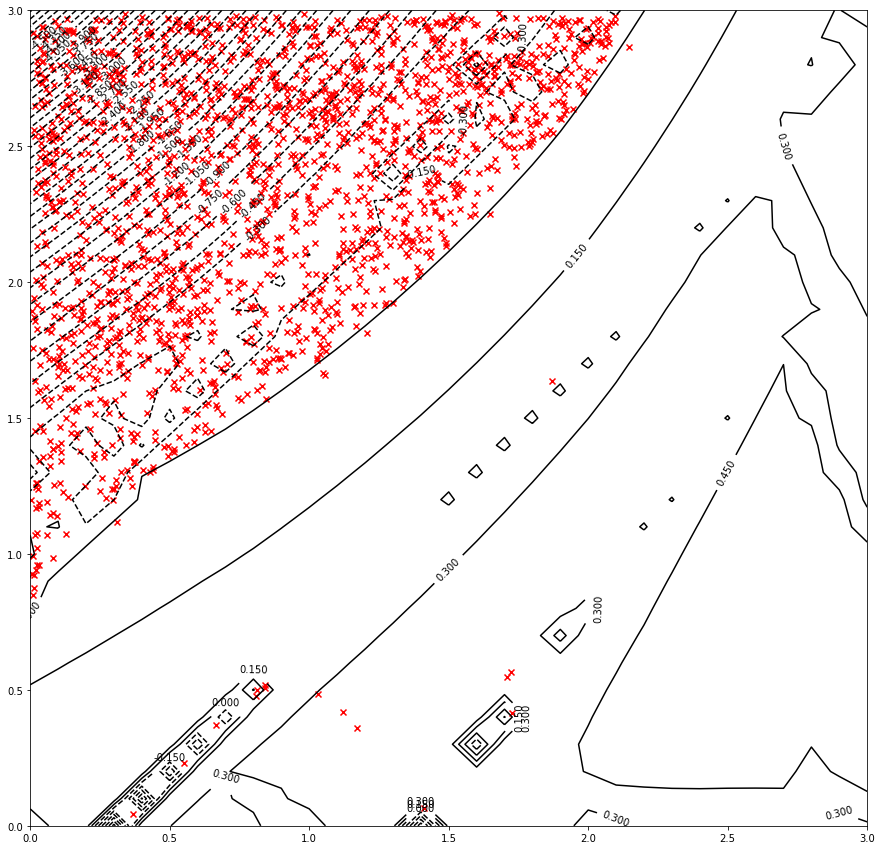

In [541]:
sample_dist = model.sample(2*n_samples).data

fig, ax = plt.subplots(figsize=(15, 15))
CS = ax.contour(X, Y, Z.view(X.shape).detach().numpy(), 40, colors="black")
ax.clabel(CS, inline=True, fontsize=10)
# ax.colorbar()
ax.scatter(sample_dist[:,0], sample_dist[:,1], marker="x", c="red")
ax.set_xlim((0, 3))
ax.set_ylim((0, 3))
# plot_data(sample_dist, color="red", alpha=0.3)
# plot_data(sample_uniform, color="white", alpha=0.3)
# plot_data(elite_samples, color="red", alpha=0.3)
plt.show()

## Gradient descent

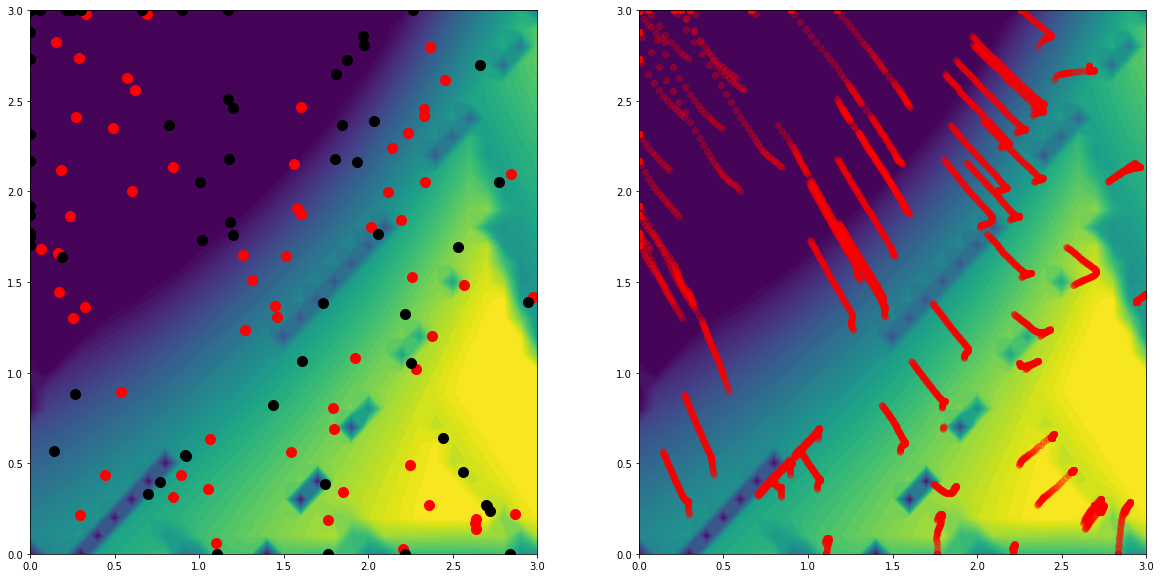

In [661]:
eps = 1E-4
precision = 4
T = 40
alpha = 0.001
lr = 0.1
n_samples = 64

adv_iter_max = 100
scale_min = 0.1
scale_max = 50
b0 = 80 / (1000.0/adv_iter_max)
c0 = 5

adv_stl_scale = lambda ep: sigmoidal_anneal(ep, scale_min, scale_max, b0, c0)

x_min = model0.standardize_x(torch.tensor([0, 0, 0, 2]))[:,:,:2]
x_max = model0.standardize_x(torch.tensor([3, 3, 0, 2]))[:,:,:2]

ic_var_xy = (torch.rand([n_samples, 1, 2]) * (xmax - xmin) + xmin)
ic_var_xy0 = ic_var_xy.clone()

fig, axs = plt.subplots(1, 2, figsize=(20,10))
ax = axs[0]
ax.contourf(X, Y, Z.relu().view(X.shape).detach().numpy(), 50)
# plt.colorbar()
ax.scatter(ic_var_xy.squeeze()[:,0], ic_var_xy.squeeze()[:,1], marker="o", c="red", s=100)
ax.set_xlim((0, 3))
ax.set_ylim((0, 3))

ax = axs[1]
ax.contourf(X, Y, Z.relu().view(X.shape).detach().numpy(), 50)
# plt.colorbar()
ax.scatter(ic_var_xy.squeeze()[:,0], ic_var_xy.squeeze()[:,1], marker="o", c="red", alpha=0.3)
ax.set_xlim((0, 3))
ax.set_ylim((0, 3))

ic_var_thv = torch.cat([torch.zeros([n_samples, 1, 1]), 2 * torch.ones([n_samples, 1, 1])], dim=-1)
ic_var = model0.standardize_x(torch.cat([ic_var_xy, ic_var_thv], dim=-1))
ic_var_xy = ic_var[:,:,:2].requires_grad_(True)
ic_var_thv = ic_var[:,:,2:]

for iteration in range(adv_iter_max):
    x_future, u_future = model0.propagate_n(T, torch.cat([ic_var_xy, ic_var_thv], dim=-1))
    complete_traj = model0.join_partial_future_signal(torch.cat([ic_var_xy, ic_var_thv], dim=-1), x_future)
    loss_stl = model0.adversarial_STL_loss(complete_traj, formula, formula_input_func, scale=adv_stl_scale(iteration))
    loss_stl.backward()

    with torch.no_grad():
        # make gradient step
        gradient = (ic_var_xy.grad * 10**precision).round() / 10**precision
        x0 = torch.clone(ic_var_xy)
        x1 = torch.clone(ic_var_xy - lr * gradient)
    #     # on the boundary + eps or outside the box & the gradient step will take it outside the box, then do not step
        ic_var_xy -= torch.where((((ic_var_xy - x_min) <= eps) | ((x_max - ic_var_xy) <= eps)).any(-1, keepdims=True) & (((x1 - x_min) <= eps) | ((x_max - x1) <= eps)).any(-1, keepdims=True), 
                              torch.zeros_like(ic_var_xy), 
                              lr * gradient)
        # project back into BRS
        count = 0
        # if any of the ic_var are outside of the BRS or outside the initial set
        # while (model.value_func(unstandardize_data(ic_var, mu_x, sigma_x)).relu().sum() > 0) | (((x_min > ic_var) | (x_max < ic_var)).any(-1, keepdims=True).sum() > 0):
        x1 = torch.clone(ic_var_xy)
        # backstepping line search
        while ((((ic_var_xy - x_min) < 0.0) | ((x_max - ic_var_xy) < 0.0)).any(-1, keepdims=True).sum() > 0):
            count += 1
            ic_var_xy += torch.where((((ic_var_xy - x_min) < 0.0) | ((x_max - ic_var_xy) < 0.0)).any(-1, keepdims=True), alpha * gradient, torch.zeros_like(ic_var_xy))

            if count > (lr // alpha) * 1.5:
                print("POOP")
                break


        ic_var_xy.grad.zero_()
    p = model0.unstandardize_x(torch.cat([ic_var_xy, ic_var_thv], dim=-1))
    ax.scatter(p.detach().squeeze()[:,0], p.detach().squeeze()[:,1], marker="o", c="red", alpha=0.3)

ax = axs[0]
p = model0.unstandardize_x(torch.cat([ic_var_xy, ic_var_thv], dim=-1))
ax.scatter(p.detach().squeeze()[:,0], p.detach().squeeze()[:,1], marker="o", c="black", s=100)
ax.set_xlim((0, 3))
ax.set_ylim((0, 3))
plt.show()




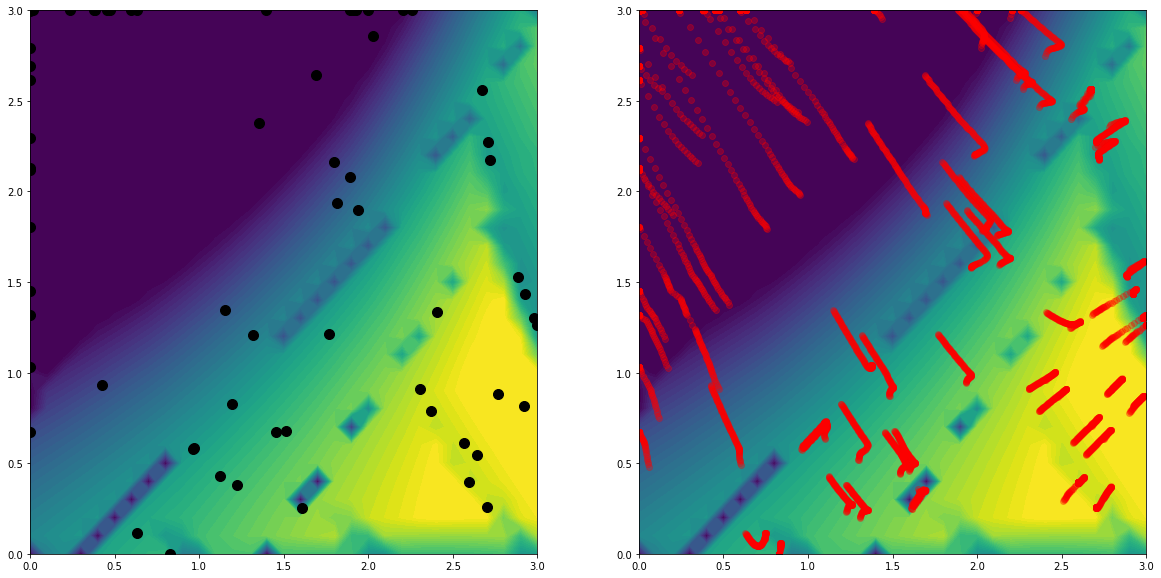

In [660]:
fig

In [317]:
env = { "covers": [Circle([8., 3.0], 2.0)],
       "obstacles": [Circle([4.5, 6.], 1.5)],
       "initial": Box([0., 0.],[3., 3.]),
       "final": Circle([1., 9.], 1.0)
        }   
env = Environment(env)
device = "cpu"
x_train_, u_train_, stats = prepare_data("expert/coverage/train.npy")
x_train = standardize_data(x_train_, stats[0][:,:,:4], stats[1][:,:,:4])
u_train = standardize_data(u_train_, stats[0][:,:,4:], stats[1][:,:,4:])
dynamics = KinematicBicycle(0.5)
hidden_dim = 64
model = STLPolicy(dynamics, hidden_dim, stats, env, dropout=0., num_layers=1)


# initial conditions set
lower = torch.tensor([env.initial.lower[0], env.initial.lower[1], -np.pi/4, 0])
upper = torch.tensor([env.initial.upper[0], env.initial.upper[1], np.pi/4, 3])

ic_ = initial_conditions(128, lower, upper)
ic = model.standardize_x(ic_)
train_loader = torch.utils.data.DataLoader(ic, batch_size=128//32, shuffle=True)


in_end_goal = inside_circle(env.final, "distance to final")
stop_in_end_goal = in_end_goal & (stlcg.Expression('speed')  < 0.5)
end_goal = stlcg.Eventually(subformula=stop_in_end_goal)
coverage = stlcg.Eventually(subformula=(always_inside_circle(env.covers[0], "distance to coverage", interval=[0,10]) & (stlcg.Expression('speed')  < 1.0)))
avoid_obs = always_outside_circle(env.obs[0], "distance to obstacle")

formula = stlcg.Until(subformula1=coverage, subformula2=end_goal) & avoid_obs
stl_graph = stlviz.make_stl_graph(formula)
stlviz.save_graph(stl_graph, "../figs/test/stl")
formula_input_func=lambda s: get_formula_input(s, env.covers[0], env.obs[0], env.final, device, backwards=False)

# if args.type == "train":
#     test(model, (x_train, u_train), formula, formula_input_func, train_loader, device)
# elif args.type == "adversarial":
#     save_model_path = "../models/coverage_run=1_lstm_dim=64_teacher_training=-1.0_weight_ctrl=0.5_weight_recon=1.0_weight_stl=-1.0_stl_max=0.2_stl_min=0.10_stl_scale=-1.0_scale_max=50.0_scale_min=0.10_iter_max=500.0"
#     adversarial(model, x_train_.shape[1]+10, formula, formula_input_func, device, save_model_path, lower, upper, iter_max=50, adv_n_samples=32)

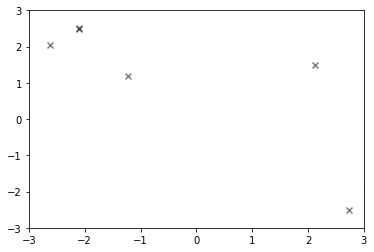

In [189]:
plot_data(samples, color="black", alpha=0.5)
plot_data(elite_samples, color="red", alpha=0.5)


In [ ]:
m = 256
top_idx = score(x[:,0], x[:,1]).sort().indices[:m]
x[top_idx,:]

In [136]:
flow = NSF_CL
flows = [flow(dim) for _ in range(3)]
prior = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = NormalizingFlowModel(prior, flows)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
if use_mixture:
    x = torch.Tensor(gen_mixture_data(n))
else:
    x = torch.Tensor(gen_data(n))

for i in range(x.shape[1]):
    x[:,i] = (x[:,i] - torch.mean(x[:,i])) / torch.std(x[:,i])

for i in range(iterations):
    optimizer.zero_grad()
    z, prior_logprob, log_det = model(x)
    logprob = prior_logprob + log_det
    loss = -torch.mean(prior_logprob + log_det)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(f"Iter: {i}\t" +
                    f"Logprob: {logprob.mean().data:.2f}\t" +
                    f"Prior: {prior_logprob.mean().data:.2f}\t" +
                    f"LogDet: {log_det.mean().data:.2f}")

Iter: 0	Logprob: -5.05	Prior: -4.31	LogDet: -0.74
Iter: 100	Logprob: -2.50	Prior: -2.79	LogDet: 0.29
Iter: 200	Logprob: -2.46	Prior: -2.80	LogDet: 0.33
Iter: 300	Logprob: -2.43	Prior: -2.80	LogDet: 0.36
Iter: 400	Logprob: -2.40	Prior: -2.81	LogDet: 0.40


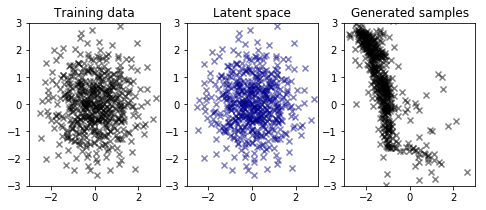

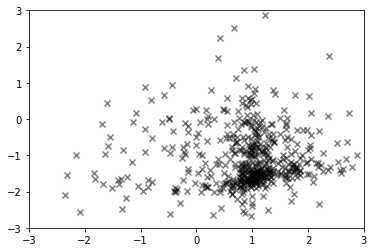

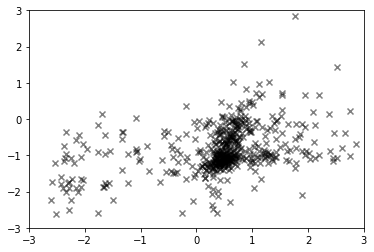

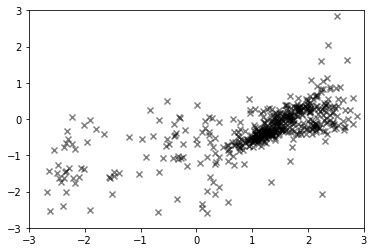

In [142]:

plt.figure(figsize=(8, 3))
plt.subplot(1, 3, 1)
plot_data(x, color="black", alpha=0.5)
plt.title("Training data")
plt.subplot(1, 3, 2)
plot_data(z.data, color="darkblue", alpha=0.5)
plt.title("Latent space")
plt.subplot(1, 3, 3)
samples = model.sample(500).data
plot_data(samples, color="black", alpha=0.5)
plt.title("Generated samples")
# plt.savefig("./examples/ex_2d.png")
plt.show()

for f in flows:
    x = f(x)[0].data
    plot_data(x, color="black", alpha=0.5)
    plt.show()



In [2]:
np.arange(-1, 1, 0.1)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01])

In [4]:
dt = 0.1
X, Y = np.meshgrid(np.arange(-1, 1+dt, dt), np.arange(-1, 1+dt, dt))
Z = np.sin(3*X*np.pi) * Y**2 + np.cos(1.5 * Y * np.pi) * X
plt.contourf(X, Y, Z, 50)
plt.colorbar()

In [42]:
Z = np.sin(3*X*np.pi) * Y**2 + np.cos(1.5 * Y * np.pi) * X
plt.contourf(X, Y, Z, 50)
plt.colorbar()

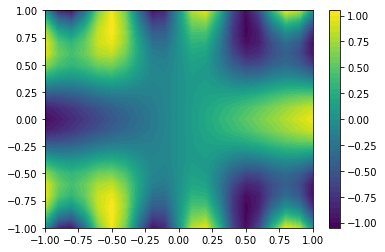

In [66]:
def score(X, Y):
    return torch.sin(3*X*np.pi) * Y**2 + torch.cos(1.5 * Y * np.pi) * X

In [50]:
class Model(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Model, self).__init__()
        self.layers = torch.nn.Sequential(torch.nn.Linear(input_dim, hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(hidden_dim, 2*hidden_dim),
                                          torch.nn.Tanh(),
                                          torch.nn.Linear(2*hidden_dim, hidden_dim),
                                          torch.nn.ReLU(),
                                          torch.nn.Linear(hidden_dim, output_dim)
                                         )
        
    def forward(self, x):
        return self.layers(x)

In [81]:
planar = Planar(2)

In [51]:
model = Model(2, 32, 2)

In [59]:
bs = 1024
z = torch.rand([bs, 2])

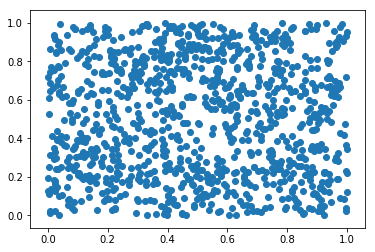

In [60]:
plt.scatter(z[:,0].numpy(), z[:,1].numpy())

In [62]:
x = model(z)

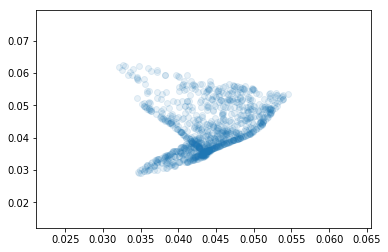

In [64]:
plt.scatter(x.detach()[:,0].numpy(), x.detach()[:,1].numpy(), alpha=0.1)

In [74]:
m = 256
top_idx = score(x[:,0], x[:,1]).sort().indices[:m]
x[top_idx,:]

tensor([[0.0322, 0.0619],
        [0.0325, 0.0610],
        [0.0326, 0.0626],
        [0.0329, 0.0622],
        [0.0333, 0.0595],
        [0.0336, 0.0603],
        [0.0339, 0.0595],
        [0.0340, 0.0613],
        [0.0345, 0.0589],
        [0.0345, 0.0583],
        [0.0345, 0.0522],
        [0.0346, 0.0584],
        [0.0347, 0.0621],
        [0.0347, 0.0578],
        [0.0347, 0.0294],
        [0.0348, 0.0291],
        [0.0349, 0.0299],
        [0.0350, 0.0289],
        [0.0352, 0.0504],
        [0.0352, 0.0304],
        [0.0354, 0.0583],
        [0.0354, 0.0499],
        [0.0354, 0.0507],
        [0.0355, 0.0497],
        [0.0356, 0.0567],
        [0.0355, 0.0297],
        [0.0355, 0.0298],
        [0.0356, 0.0495],
        [0.0355, 0.0308],
        [0.0357, 0.0494],
        [0.0356, 0.0302],
        [0.0358, 0.0544],
        [0.0359, 0.0539],
        [0.0360, 0.0616],
        [0.0359, 0.0490],
        [0.0358, 0.0297],
        [0.0359, 0.0311],
        [0.0359, 0.0314],
        [0.0